In [29]:
import s3fs
import boto3
import time

from PIL import Image
import numpy as np
import hashlib
import io
import json
import gc
from tqdm import tqdm
import pandas as pd
import os

import torch
from torchvision import models
from torchvision import transforms, models
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt

import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay,classification_report

In [18]:
def init_clients():
    return boto3.client("s3"), s3fs.S3FileSystem()

boto3_s3, s3fs_ = init_clients()

In [19]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

Using device: cuda



In [20]:
def data_loading(path):
    with open(path, 'r') as file:
        test_data = json.load(file)
    x = list(test_data.keys())
    y = list(test_data.values())
    train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=0.3, random_state=42,stratify=y)
    return train_x, test_x, train_y, test_y

In [21]:
def data_loading_COMPCAR():
    train_x, test_x, train_y, test_y = data_loading('TESTDATA.json')

    with open('COMPCAR.json', 'r') as file:
        test_data = json.load(file)
    x = list(test_data.keys())
    y = list(test_data.values())
    train_x_2, test_x_2, train_y_2, test_y_2 = train_test_split(x, y, test_size=0.90, random_state=42,stratify=y)

    train_x.extend(train_x_2)
    train_y.extend(train_y_2)
    
    test_x.extend(test_x_2[:1500])
    test_y.extend(test_y_2[:1500])
    return train_x, test_x, train_y, test_y

In [22]:
def preprocess_image(image_bytes):
    # Open the image as bytes
    image = Image.open(io.BytesIO(image_bytes))

    # Convert to grayscale
    if image.mode != 'RGB':
        image = image.convert('RGB')

    # Convert image to numpy array
    image_np = np.array(image)

    # Convert the numpy array to PyTorch tensor
    image_tensor = torch.tensor(image_np)

    # Convert the tensor to 3D RGB (if it's not already)
    if len(image_tensor.shape) == 2:
        image_tensor = image_tensor.unsqueeze(0)  # Add batch dimension
    image_tensor = image_tensor.permute(2, 0, 1)  # Convert HWC to CHW

    # Normalize to [0, 1]
    image_tensor = image_tensor.float() / 255.0

    return image_tensor


def process_duplicates_image_ids(model, image_paths: list, batch_size: int,
                                 bucket: str, boto_s3: boto3.client("s3"), 
                                 s3fs_: s3fs.S3FileSystem(), target_size=(256, 256)):
    models = ['ResNet','VGG16', 'SVM', 'YOLO','Inception']
    if model in models:
        preprocess = transforms.Compose([transforms.Resize(target_size), transforms.ToTensor(),])

    image_tensors = []
    for i in tqdm(range(0, len(image_paths), batch_size), total=batch_size, desc='Processing Images'):
        batch_image_paths = image_paths[i:i + batch_size]
        batch_image_tensors = []
        for ad_image in batch_image_paths:
            if ad_image.lower().endswith(('.jpg', '.jpeg', '.png')):
                image_path = "/".join(ad_image.split("/")[1:])
                s3_object = boto_s3.get_object(Bucket=bucket, Key=image_path)
                image_bytes = s3_object['Body'].read()
                image_tensor = preprocess_image(image_bytes)
                batch_image_tensors.append(image_tensor)
        # Resize or crop images to the target size before stacking
        batch_image_tensors_resized = [transforms.functional.resize(image, target_size) for image in batch_image_tensors]
        image_tensors.append(torch.stack(batch_image_tensors_resized))

    # Concatenate processed batches
    processed_image_tensors = torch.cat(image_tensors, dim=0)

    # Display the shape and dtype of the tensor
    print("Tensor Shape:", processed_image_tensors.shape)
    print("Tensor Dtype:", processed_image_tensors.dtype)

    return processed_image_tensors

In [23]:
class CustomDataset(Dataset):
    def __init__(self, images, targets):
        self.images = images
        self.targets = targets

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        target = self.targets[idx]

        # Convert target label to one-hot encoded tensor
        target_tensor = torch.tensor([target], dtype=torch.float32)

        return image, target_tensor

def dataloader(im,train_y,im_test,test_y):
    train_images, val_images, train_targets, val_targets = train_test_split(im, train_y, test_size=0.3, random_state=42,stratify=train_y)

    train_dataset = CustomDataset(train_images, train_targets)
    val_dataset = CustomDataset(val_images, val_targets)
    
    test_dataset = CustomDataset(im_test, test_y)

    train_batch_size = 32
    val_batch_size = 32
    test_batch_size = 32

    train_loader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=val_batch_size)
    test_loader = DataLoader(test_dataset, batch_size=test_batch_size)
    
    return train_loader,val_loader,test_loader

In [24]:
def train_trainedGOOGLE(epochs, train_loader, val_loader):
    start_time = time.time()
    model = models.googlenet(pretrained=True).to(device)
    model.aux_logits = False
    for param in model.parameters():
        param.requires_grad = False   
    model.fc = nn.Sequential(
        nn.Linear(1024, 1),  # Output layer with 5 units for multi-class classification
        nn.Sigmoid()
    ).to(device)

    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.fc.parameters())

    num_epochs = epochs
    train_losses = []
    validation_losses = []

    best_validation_loss = float('inf')
    best_model_state = None

    for epoch in range(num_epochs):
        model.train()
        for images, targets in train_loader:
            images, targets = images.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, targets).to(device)
            loss.backward()
            optimizer.step()

        model.eval()
        with torch.no_grad():
            train_loss = 0.0
            for images, targets in val_loader:
                images, targets = images.to(device), targets.to(device)
                outputs = model(images)
                val_loss = criterion(outputs, targets).to(device)
                train_loss += val_loss.item()

        train_loss /= len(val_loader)
        validation_loss = val_loss.item()

        train_losses.append(train_loss)
        validation_losses.append(validation_loss)

        if validation_loss < best_validation_loss:
            best_validation_loss = validation_loss
            best_model_state = model.state_dict()

        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss}, Val Loss: {validation_loss}')

    plt.plot(range(1, num_epochs + 1), train_losses, label='Training set')
    plt.plot(range(1, num_epochs + 1), validation_losses, label='Validation set')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and validation loss GoogleNet')
    plt.legend()
    plt.savefig('training_validation_figure.png')
    plt.show()

    torch.save(best_model_state, 'model_google_intext.pth')
    end_time = time.time()
    print("Time taken for training:", end_time - start_time, "seconds")
    return best_model_state, model


In [25]:
def test_GOOGLE(best_model_state, model, test_loader):
    start_time = time.time()

    model.load_state_dict(best_model_state)
    model.eval()

    predictions = []
    with torch.no_grad():
        for images, _ in test_loader:
            images = images.to(device)
            outputs = model(images)
            predictions.append(outputs)

    predictions = torch.cat(predictions, dim=0).to(device)
    threshold = 0.5
    predicted_labels = (predictions > threshold).float()

    predicted_labels = predicted_labels.int()

    result = predicted_labels.squeeze().tolist()
    end_time = time.time()
    print("Time taken for testing:", end_time - start_time, "seconds")
    return result


In [26]:
def show_matrix(test_y,result,filename=None):
    print(classification_report(test_y, result))
    cm = confusion_matrix(test_y, result)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=['interior','exterior'])
    disp.plot()
    if filename:
        plt.savefig(filename)
    else:
        plt.show()

In [27]:
def main_trainedGoogle():
    train_x, test_x, train_y, test_y = data_loading_COMPCAR()
    im = process_duplicates_image_ids('Inception',image_paths=train_x,batch_size=100,bucket="dpgos-osdata-boaz-beukers-sandbox",
        boto_s3=boto3_s3,
        s3fs_=s3fs_)
    im_test = process_duplicates_image_ids('Inception',image_paths=test_x,batch_size=100,bucket="dpgos-osdata-boaz-beukers-sandbox",
        boto_s3=boto3_s3,
        s3fs_=s3fs_)
    train_loader,val_loader,test_loader = dataloader(im,train_y,im_test,test_y)
    best_model,model = train_trainedGOOGLE(30,train_loader,val_loader)
    result = test_GOOGLE(best_model,model,test_loader)
    matrix = show_matrix(test_y,result,filename='ANGLE_trainedGOOGLENET_results.png')

Processing Images:   0%|          | 0/100 [00:00<?, ?it/s]/home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
Processing Images:  54%|█████▍    | 54/100 [07:52<06:42,  8.76s/it]


Tensor Shape: torch.Size([5324, 3, 256, 256])
Tensor Dtype: torch.float32


Processing Images:  27%|██▋       | 27/100 [03:49<10:20,  8.50s/it]


Tensor Shape: torch.Size([2661, 3, 256, 256])
Tensor Dtype: torch.float32


/home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /home/ec2-user/.cache/torch/hub/checkpoints/googlenet-1378be20.pth
100%|██████████| 49.7M/49.7M [00:00<00:00, 135MB/s]


Epoch 1/30, Train Loss: 0.21059586405754088, Val Loss: 0.18773169815540314
Epoch 2/30, Train Loss: 0.14295362889766694, Val Loss: 0.12199408560991287
Epoch 3/30, Train Loss: 0.11455515071749688, Val Loss: 0.10259880870580673
Epoch 4/30, Train Loss: 0.10556824125349522, Val Loss: 0.10575813055038452
Epoch 5/30, Train Loss: 0.09342943906784057, Val Loss: 0.09404660016298294
Epoch 6/30, Train Loss: 0.08607908226549625, Val Loss: 0.08164012432098389
Epoch 7/30, Train Loss: 0.07994370374828577, Val Loss: 0.07704779505729675
Epoch 8/30, Train Loss: 0.07761281691491603, Val Loss: 0.09084907919168472
Epoch 9/30, Train Loss: 0.07309696692973375, Val Loss: 0.0815185084939003
Epoch 10/30, Train Loss: 0.07618148986250162, Val Loss: 0.08624913543462753
Epoch 11/30, Train Loss: 0.06898135179653764, Val Loss: 0.08892001956701279
Epoch 12/30, Train Loss: 0.07143110364675521, Val Loss: 0.08656424283981323
Epoch 13/30, Train Loss: 0.06561649326235056, Val Loss: 0.0833381786942482
Epoch 14/30, Train Loss

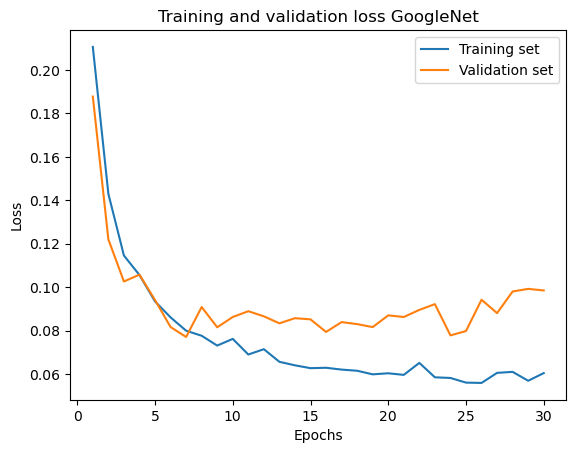

Time taken for training: 231.50306797027588 seconds
Time taken for testing: 3.6443395614624023 seconds
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      1477
           1       0.99      0.96      0.97      1184

    accuracy                           0.98      2661
   macro avg       0.98      0.98      0.98      2661
weighted avg       0.98      0.98      0.98      2661



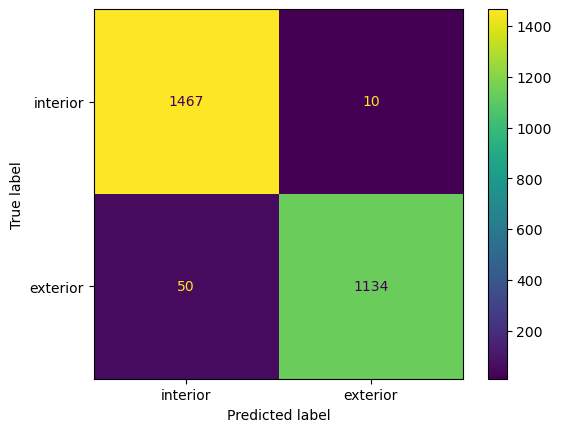

In [30]:
main_trainedGoogle()